In [1]:
import warnings
warnings.filterwarnings('ignore')

from llama_index.llms.openai import OpenAI
from src.local_models.embeddings import get_embed_model


from llama_index.core.retrievers import VectorIndexRetriever, KGTableRetriever
from src.retrievers.retrieval import CustomRetriever
from src.data_loader.load_from_dir import rebuild_index

from src.nebula_graph.nebula_operations import show_hosts, add_hosts_if_not_available, show_spaces, init_nebula_cluster
from src.nebula_graph.text_2_graph import df_to_fig, extract_triplets, get_response_n_kg_rel_query, get_response_n_kg_rel_chat

#from llama_index.core import Document
import os, re, ast
import pandas as pd

from typing import Dict, List
from dotenv import load_dotenv

In [2]:
from llama_index.graph_stores.nebula import NebulaGraphStore
from llama_index.core import KnowledgeGraphIndex, VectorStoreIndex, SimpleDirectoryReader

from llama_index.core.response_synthesizers import get_response_synthesizer
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core import PromptTemplate


In [3]:
load_dotenv(override=True)

True

In [ ]:
#add_hosts_if_not_available()


In [ ]:
#space_name = "kdp_whitepaper"
#init_nebula_cluster(space_name)

In [ ]:
#edge_types, rel_prop_names = ["relationship"], ["relationship"] # default, could be omit if create from an empty kg
#tags = ["entity"]

#graph_store = NebulaGraphStore(
    #space_name=space_name,
    #edge_types=edge_types,
    #rel_prop_names=rel_prop_names,
    #tags=tags,
#)


In [4]:
embed_model = get_embed_model(model_name=os.environ['embed_path'],  model_kwargs={'device': 'cpu'}, encode_kwargs = {'normalize_embeddings': True})
#llm = MyLLM(pretrained_model_name_or_path=os.environ['llm_path'], device_map="mps", context_window=4096, num_output=512, model_name='chatglm3-6b')
llm = OpenAI()

In [5]:
kg_index = rebuild_index('db_stores/kg_index')

In [ ]:
#first-time build

#documents = SimpleDirectoryReader('data/产品白皮书/').load_data()
#kg_index = KnowledgeGraphIndex.from_documents(
    #documents,
    #max_triplets_per_chunk=10,
    #space_name=space_name,
    #edge_types=edge_types,
    #rel_prop_names=rel_prop_names,
    #tags=tags,
#)

#kg_index.storage_context.persist(persist_dir="db/kg_index")

In [6]:
kg_rag_query_engine = kg_index.as_query_engine(
    include_text=True,
    retriever_mode="hybrid",
    response_mode="tree_summarize",
)


In [7]:
response = kg_rag_query_engine.query("云原生和传统大数据平台的区别是什么")
#云原生和传统大数据平台的区别是什么
#KDP中flink的版本号是多少
#KDP对K8s做了哪些改造

Response(response='Hello! How can I assist you today?', source_nodes=[NodeWithScore(node=TextNode(id_='07459013-0a17-4de7-b8f5-e306f6593abc', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='No relationships found.', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=1.0)], metadata={'07459013-0a17-4de7-b8f5-e306f6593abc': {}})

In [8]:
resp, kg_rel_texts = get_response_n_kg_rel_query(response)

In [ ]:
kg_rel_texts

In [9]:
#format ER triplets (unidirectional)
def extract_triplets(data):
    """:params data: List(kg_rel_texts)"""
    triplets = [ast.literal_eval(data[i]) for i in range(len(data))]
    
    #remove duplicates
    unique_triplets = [list(tpl) for tpl in set([tuple(lst) for lst in triplets])]
    #format as DF
    tri_df = pd.DataFrame(unique_triplets).rename(columns={0: 'e1', 1: 'r', 2: 'e2'})

    return tri_df

In [10]:
extracted_triplets = extract_triplets(kg_rel_texts)
extracted_triplets

,e1,r,e2
0,大数据平台,构建,公司
1,大数据平台,需要,熟练技能
2,大数据平台,需要,了解和掌握
3,云原生,多租户,管理
4,公司,每年,大数据平台的运维人力成本
5,云原生,安全,管理
6,大数据平台,满足不了,自助式需要
7,大数据架构优势,是,云原生
8,大数据架构优势,有,优势
9,云原生,有,大数据架构优势


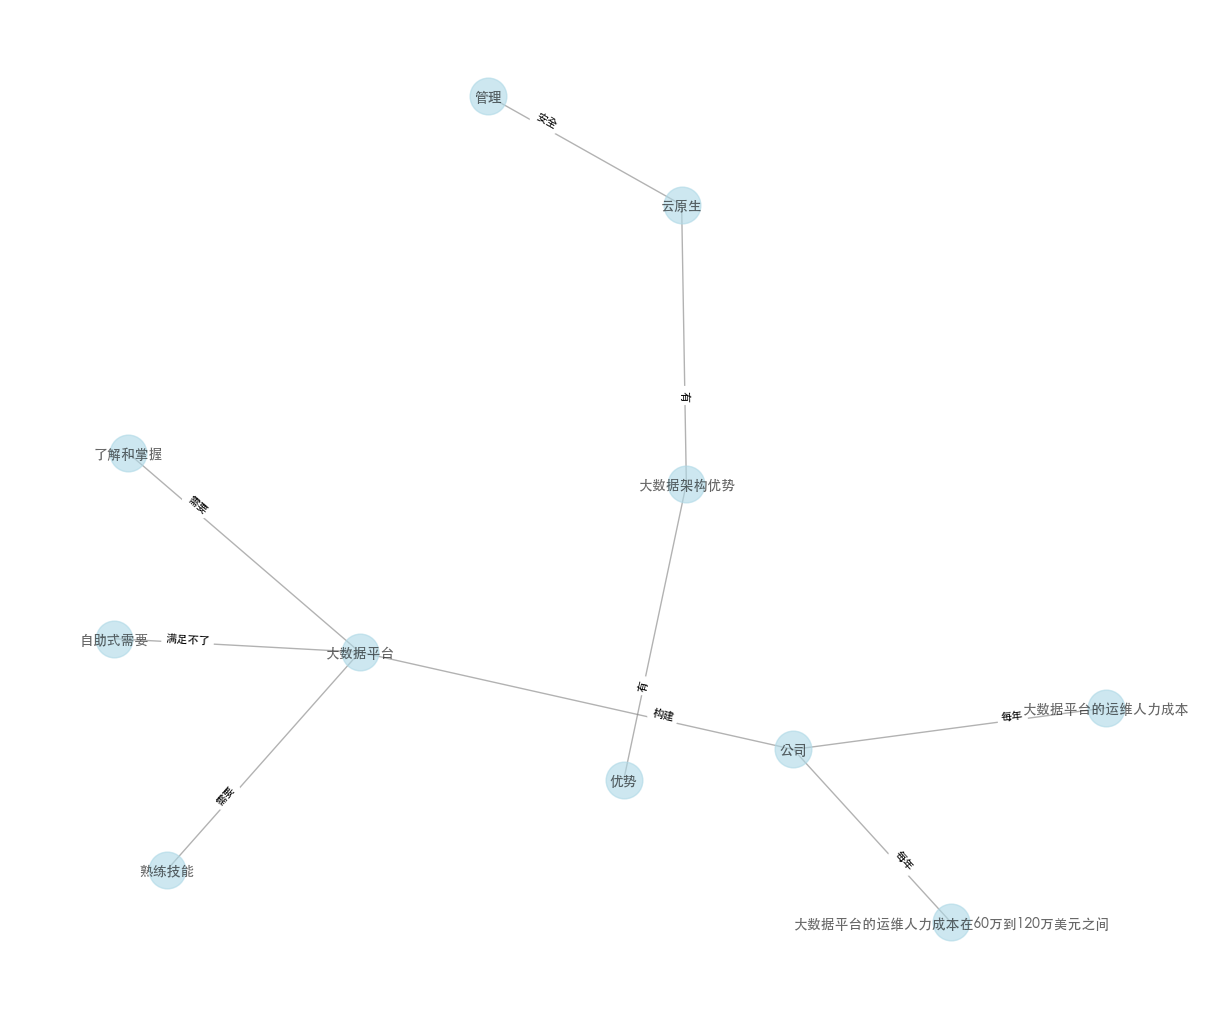

In [11]:
kg_fig = df_to_fig(extracted_triplets, show_fig=True)

In [15]:
import os, io, sys, traceback




class OutputCapture:
    def __init__(self):
        self.buffer = io.StringIO()

    def isatty(self):
        return False

    def write(self, message):
        self.buffer.write(message)

    def flush(self):
        pass

    def get_output(self):
        return self.buffer.getvalue()
    
SHOW_TRACE_ON_UI = True

def process_query(prompt):
    captured_output_str = "No trace available!"
    response = ""
    try:
        if SHOW_TRACE_ON_UI:
            captured_output = OutputCapture()
            sys.stdout = captured_output
        response = kg_rag_query_engine.query(prompt)
        if SHOW_TRACE_ON_UI:
            sys.stdout = sys.__stdout__

        if SHOW_TRACE_ON_UI and captured_output is not None:
            captured_output_str = captured_output.get_output()
            
    except Exception as e:
        response = f"Error:\n{str(e)}"
        traceback.print_exc()
    return (response, captured_output_str)

In [17]:
response, captured_output_str = process_query('hi')

In [19]:
response.response

'Hello! How can I assist you today?'

In [22]:
get_response_n_kg_rel_query(response)

('Hello! How can I assist you today?', None)